In [331]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
food_data = pd.read_csv('data/food.csv')
ratings_data = pd.read_csv('data/ratings.csv')

In [332]:
ratings_data

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0
...,...,...,...
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0


In [333]:
# Merge data
merged_data = pd.merge(ratings_data, food_data, on='Food_ID')

# Define a Reader
reader = Reader(rating_scale=(1, 10))

# Create Surprise Dataset
data = Dataset.load_from_df(merged_data[['User_ID', 'Food_ID', 'Rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [334]:
merged_data.head()

,User_ID,Food_ID,Rating,Name,C_Type,Veg_Non,Describe
0,1.0,88.0,4.0,peri peri chicken satay,Snack,non-veg,"boneless skinless chicken thigh (trimmed), sal..."
1,1.0,46.0,3.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."
2,3.0,46.0,2.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."
3,20.0,46.0,6.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."
4,69.0,46.0,9.0,steam bunny chicken bao,Japanese,non-veg,"buns, all purpose white flour, dry yeast, suga..."


C:\Users\jules\AppData\Local\Temp\ipykernel_8824\2002446591.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


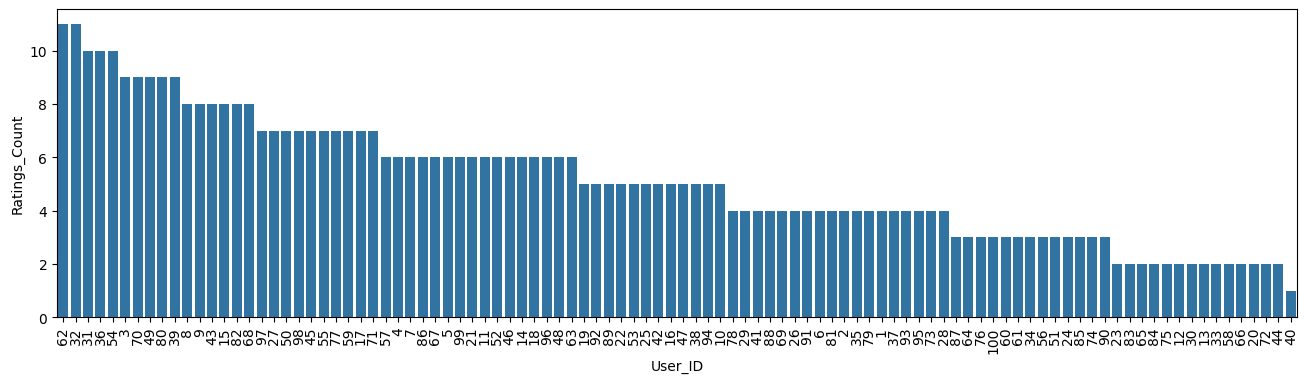

In [335]:
user_ratings_count = merged_data['User_ID'].value_counts().reset_index()
user_ratings_count.columns = ['User_ID', 'Ratings_Count']
user_ratings_count = user_ratings_count.sort_values('Ratings_Count', ascending=False)
user_ratings_count['User_ID'] = user_ratings_count['User_ID'].astype(int).astype(str)

plt.figure(figsize=(16, 4))
ax = sns.barplot(x='User_ID', y='Ratings_Count', data=user_ratings_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Un maximum de 11 ratings pour 309 recettes et seulement 100 utilisateurs, c'est pas beaucoup

In [336]:
# Define the similarity options (cosine similarity in this case)
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Build the collaborative filtering model
model = KNNBasic(sim_options=sim_options)


In [337]:
# Train the model
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


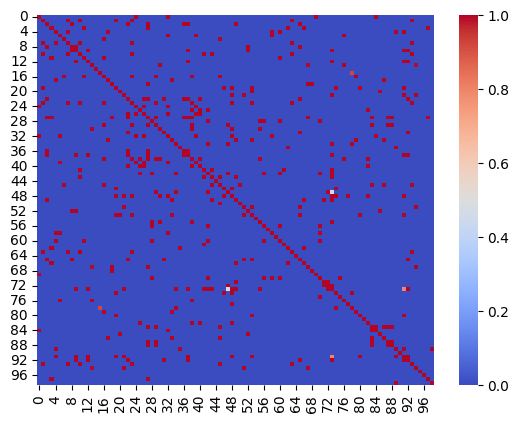

In [338]:
# Print the similarity matrix as a heatmap
sns.heatmap(model.sim, cmap='coolwarm')
plt.show()

In [339]:
def user_based_recommendation(user_ID):
    # Get the list of all food IDs
    food_ids = merged_data['Food_ID'].unique()

    # Get the list of food IDs rated by the user
    food_ids_user_rated = merged_data[merged_data['User_ID'] == user_ID]['Food_ID'].values

    # Get the list of food IDs not rated by the user
    food_ids_user_not_rated = [food_id for food_id in food_ids if food_id not in food_ids_user_rated]

    # Create a list of tuples in the format (food_id, user_id, rating) for all food IDs not rated by the user
    food_ids_user_not_rated = [(food_id, user_ID, 0) for food_id in food_ids_user_not_rated]

    # Predict ratings for all food IDs not rated by the user
    predictions = model.test(food_ids_user_not_rated)

    # Get top 10 predictions
    recommendations = []
    for food_id, user_id, rating, _, _ in predictions:
        recommendations.append((food_id, rating))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    recommendations = recommendations[:10]

    # Get food names
    food_names = []
    for recommendation in recommendations:
        food_names.append(food_data[food_data['Food_ID'] == recommendation[0]]['Name'].values[0])

    return food_names

In [340]:
# Get top 10 recommendations for test user
test_user = 32

print("Ratings given by user {}:".format(test_user))
user_ratings = merged_data[merged_data['User_ID'] == test_user]
print(user_ratings[['Name', 'Rating']].sort_values('Rating', ascending=False))

# Get top 10 recommendations for test user
print("\nTop 10 recommendations for user {}:".format(test_user))
user_based_recommendation(test_user)

Ratings given by user 32:
                                       Name  Rating
286                           chicken sukka    10.0
143  cajun spiced turkey wrapped with bacon     9.0
113       jalebi with fennel yogurt pudding     8.0
285            sweet potato and quinoa bowl     7.0
290                          butter chicken     7.0
291                             puffed rice     5.0
282               almond and amaranth ladoo     4.0
103                         chicken biryani     2.0
23                       carrot ginger soup     1.0
287               holi special bhang pakode     1.0
288                     seafood rock filler     1.0

Top 10 recommendations for user 32:


['peri peri chicken satay',
 'steam bunny chicken bao',
 'green lentil dessert fudge',
 'cashew nut cookies',
 'christmas tree pizza',
 'moong dal kiwi coconut soup',
 'chicken nimbu dhaniya shorba',
 'hot chocolate',
 'chicken and mushroom lasagna',
 'egg and garlic fried rice']

In [341]:
# Make predictions on the test set
predictions = model.test(testset)

In [342]:
# Evaluate the model
accuracy.rmse(predictions)

RMSE: 3.0914


3.0914219641571106